# This example shows how to setup a TW accelerating structure from a 1D field map

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Load the field map from disk

In [3]:
T = load('data/TWS_Sband.dat');
T(1:10, :)

ans =

            0            0            0
   5.6078e-04   2.4438e-04   1.4964e-20
   1.1216e-03   4.8800e-04   2.9881e-20
   1.6823e-03   7.3010e-04   4.4706e-20
   2.2431e-03   9.7002e-04   5.9397e-20
   2.8039e-03   1.2071e-03   7.3917e-20
   3.3647e-03   1.4410e-03   8.8236e-20
   3.9255e-03   1.6712e-03   1.0233e-19
   4.4862e-03   1.8976e-03   1.1619e-19
   5.0470e-03   2.1201e-03   1.2982e-19



## Prepares for the RF-Track element
* $E_z$ is the on-axis electric field, in complex form, on a regular 1D mesh
* $h_z$ is the mesh step

In [4]:
Ez = T(:,2) + 1j * T(:,3); % V/m
hz = T(2,1) - T(1,1); % m

Let's have a look at the field

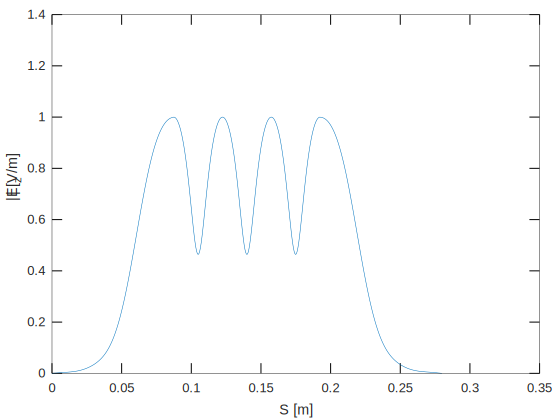

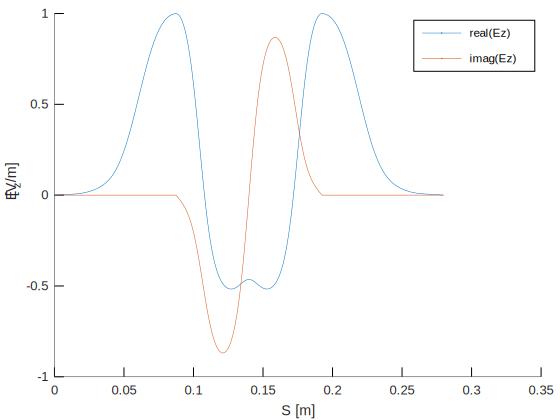

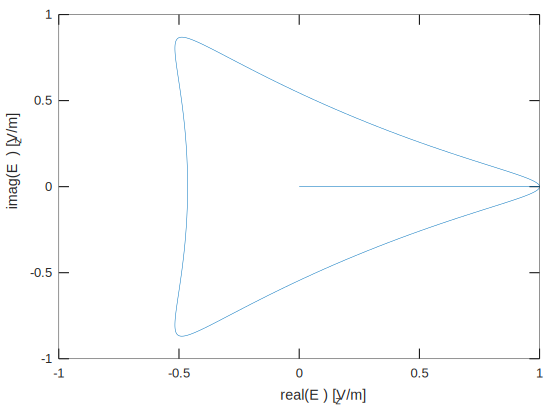

In [5]:
figure
plot(T(:,1), abs(Ez));
xlabel('S [m]');
ylabel('|E_z| [V/m]');

figure
hold on
plot(T(:,1), real(Ez));
plot(T(:,1), imag(Ez));
legend('real(Ez)', 'imag(Ez)');
xlabel('S [m]');
ylabel('E_z [V/m]');

figure
plot(real(Ez), imag(Ez))
xlabel('real(E_z) [V/m]');
ylabel('imag(E_z) [V/m]');

## Create a new element

Now we create a new element to be used for tracking

In [6]:
phid = 0; % degrees
freq = 2.856e9; % Hz

scaling = 1e6;

RF = RF_FieldMap_1d (Ez * scaling, hz, -1, freq, +1); % V/m, m, length/m, Hz, +1,0,-1

RF.set_phid(phid);
RF.set_odeint_algorithm('rk2'); % integration algorithm
RF.set_nsteps(1000); % number of integration steps
RF.set_tt_nsteps(100); % transport table

In [7]:
RF.get_length()
RF.get_period() / RF_Track.ns

ans = 0.2798
ans = 0.3501


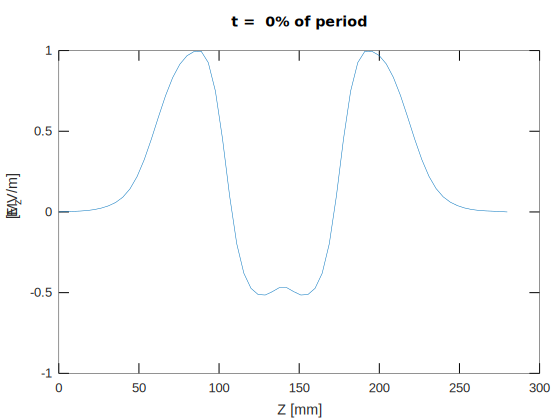

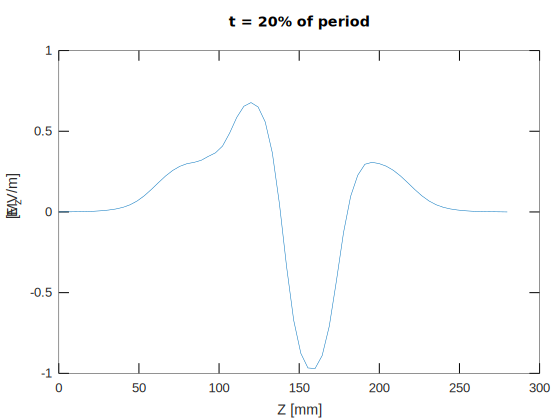

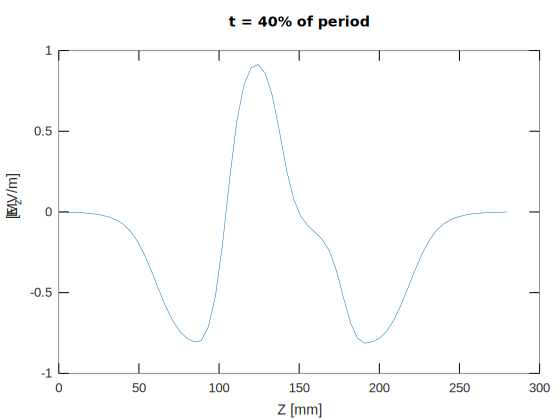

In [8]:
RF.set_t0(0.0);

T_period = RF.get_period(); % mm/c

Z = linspace(0, RF.get_length()*1e3, 64); % mm

for t = [ 0.0 0.2 0.4 ]*T_period

    % read the field
    [E,B] = RF.get_field(0, 0, Z, t); % X, Y, Z, T  (mm, mm, mm, mm/c)
    
    figure;
    plot(Z, E(:,3)/1e6);
    title(sprintf('t = %2.f%% of period', t*100/T_period));
    xlabel('Z [mm]');
    ylabel('E_z [MV/m]');
    
end

RF.unset_t0();

In [9]:
RF.get_field(0, 5, 20, 0.6)

ans =

            0
  -3.2375e+03
   1.1169e+04

ans =

   2.0261e-07
            0
            0



## Introducing "autophase"
First, let's define a reference particle

In [10]:
P0 = Bunch6d (RF_Track.electronmass, 0.0, -1, [ 0 0 0 0 0 100 ]);

In [11]:
L = Lattice();
L.append(RF);
L.append(RF);
L.append(RF);
L.append(RF);

Autophase sets the reference time $t_0$ of each RF element such that $\phi_\text{RF}=0$ corresponds to on-crest acceleration

In [12]:
P_final = L.autophase (P0)

P_final = 100.41


In [13]:
for i=1:4
    L{i}.get_t0()
end

ans = 34.951
ans = -0.1239
ans = 69.770
ans = 34.696


In [14]:
P1 = L.track (P0);
P1.get_phase_space()

ans =

            0            0            0            0   1.1193e+03   1.0041e+02



ans = 1.1193


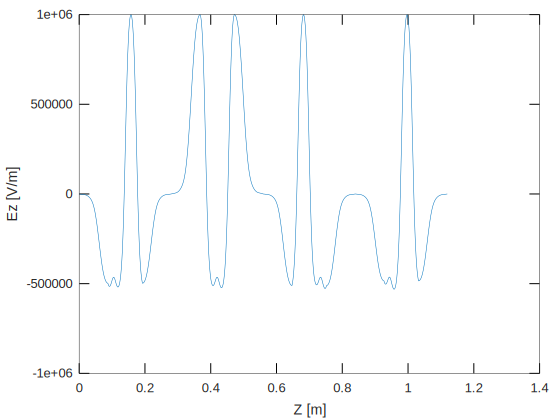

In [15]:
L.get_length()

Z = linspace(0, L.get_length()*1e3, 1001);

[E,B] = L.get_field (0, 0, Z, 0);

plot(Z/1e3, E(:,3))
xlabel('Z [m]')
ylabel('Ez [V/m]')


In [16]:
P1 = L.track (P0);
P1.get_phase_space()

ans =

            0            0            0            0   1.1193e+03   1.0041e+02



In [17]:
T = L.get_transport_table('%S %mean_t %mean_E');

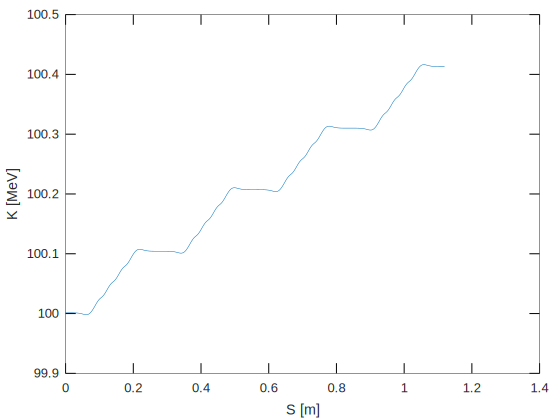

In [18]:
plot(T(:,1), T(:,2) / RF_Track.ns)
xlabel('S [m]')
ylabel('t [ns]') 

plot(T(:,1), T(:,3))
xlabel('S [m]')
ylabel('K [MeV]') 

## Let's track a bunch through this linac

In [19]:
%% Define Twiss parameters
Twiss = Bunch6d_twiss();
Twiss.sigma_t = 1; % mm/c
Twiss.sigma_pt = 1; % permille
Twiss.emitt_x = 0.001;
Twiss.beta_x = 1;

%% Create the bunch
B0 = Bunch6d (RF_Track.electronmass, 0.0, -1, 100, Twiss, 10000);

B1 = L.track (B0);

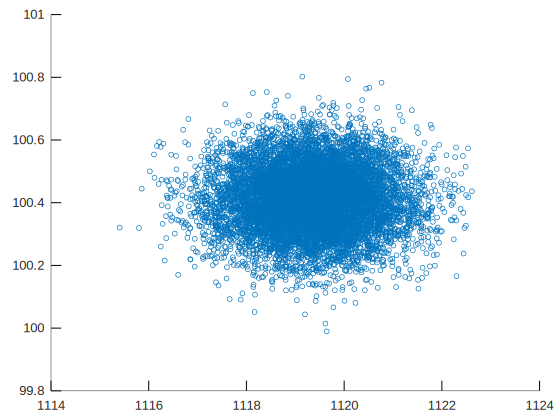

In [20]:
M1 = B1.get_phase_space();
scatter(M1(:,5), M1(:,6))